In [2]:
import numpy as np
frame_offsets=np.linspace(-2.0,2.0,41)

VirtualGImbalに送る設定用のJSONファイルを生成する

In [3]:
import json

# with open('output.json', 'w') as f:
#     obj={"frame_offset":0.0, "path_prefix":str(0.0)}
#     json.dump(obj, f)

複数の設定をそれぞれjsonに書き出して実行
build/以下におく


In [4]:
for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

VirtualGimbalを順に起動する

オフセット変えたときの4Aをプロットする

In [5]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity)-1-length,length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(12,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [6]:
import subprocess

In [7]:
def exec_vg(offset): # Vaio10
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/Videos/C0006.MP4 -c ILCE-6500i -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [8]:
def exec_vg(offset): # Mac + Pallarels
    cmd = './pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0006.MP4 -c ILCE-6500i -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [8]:
for fo in frame_offsets:
    exec_vg(fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


全部のグラフを結合して表示してみる

In [9]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:]
    else:
        datas = np.append(datas,data[1:],axis=0)

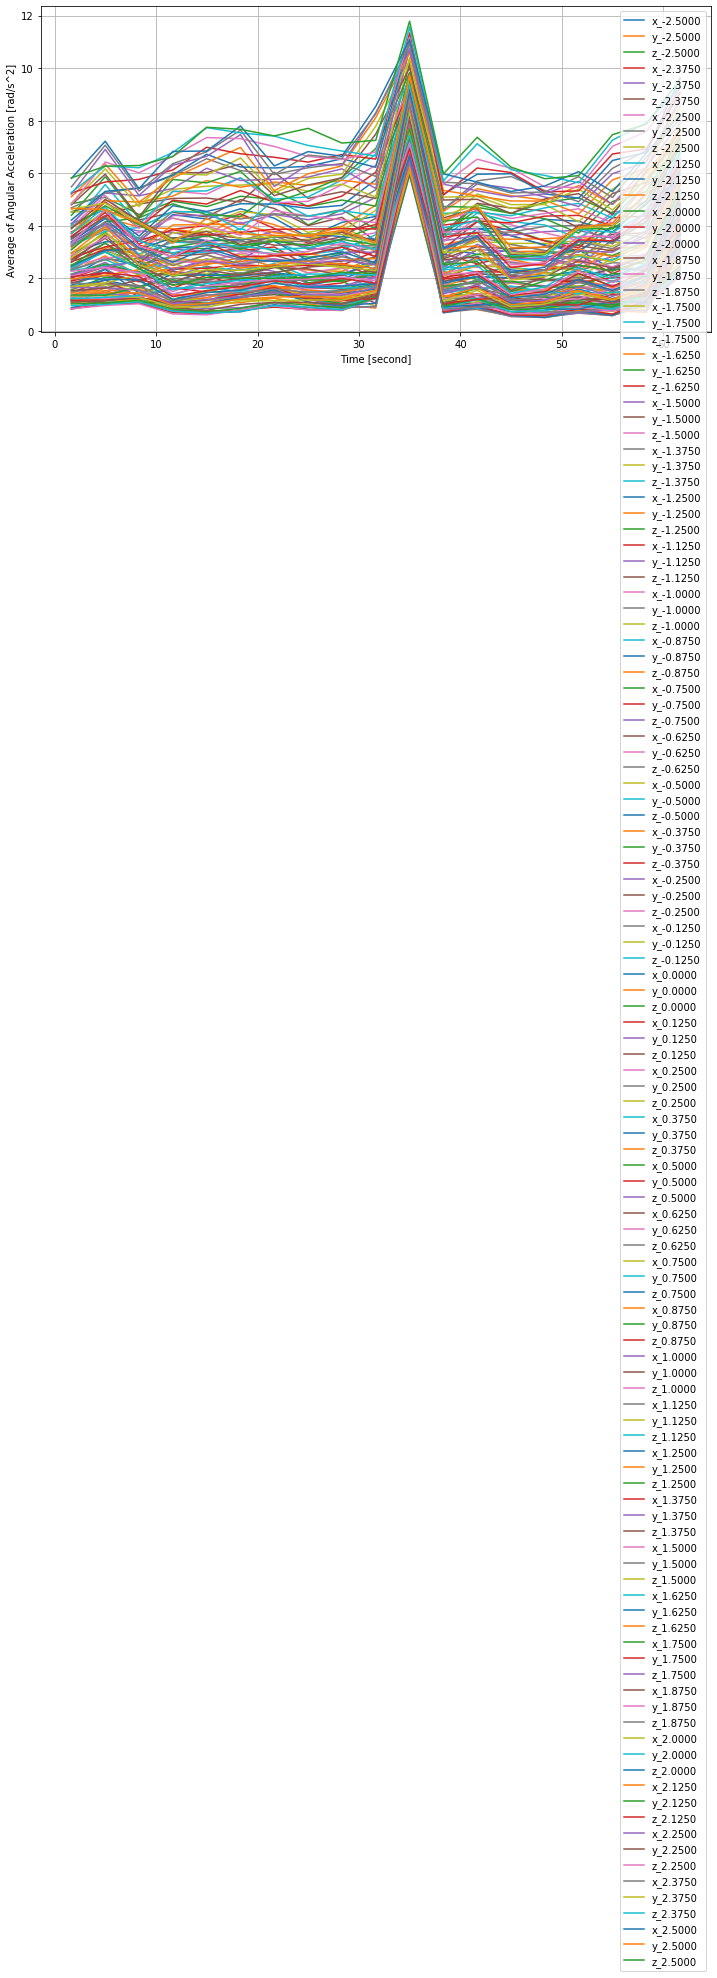

In [10]:
plotA4s(datas,legend,sampling_rate=30,length=100)

In [11]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:2]
    else:
        datas = np.append(datas,data[1:2],axis=0)

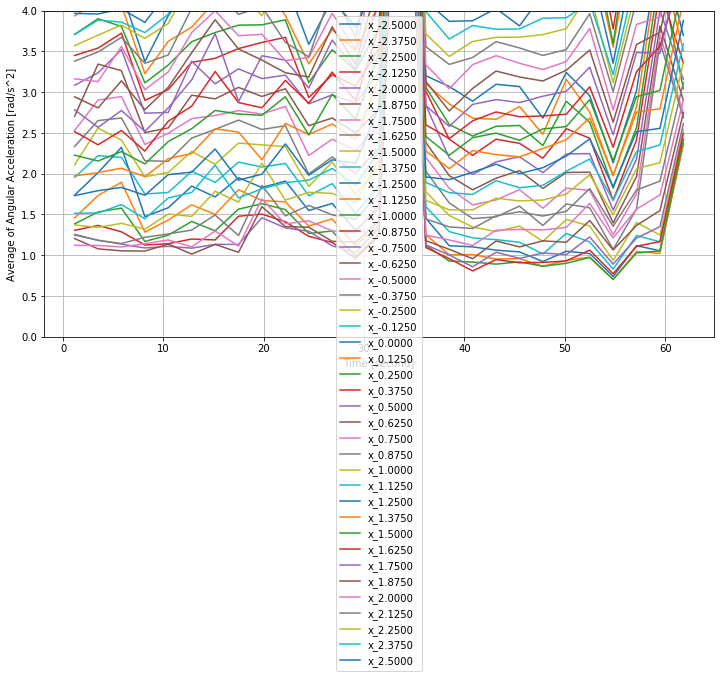

In [12]:
plotA4s(datas,legend,sampling_rate=30,length=70,ylim=[0,4])

In [13]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[2:3]
    else:
        datas = np.append(datas,data[2:3],axis=0)

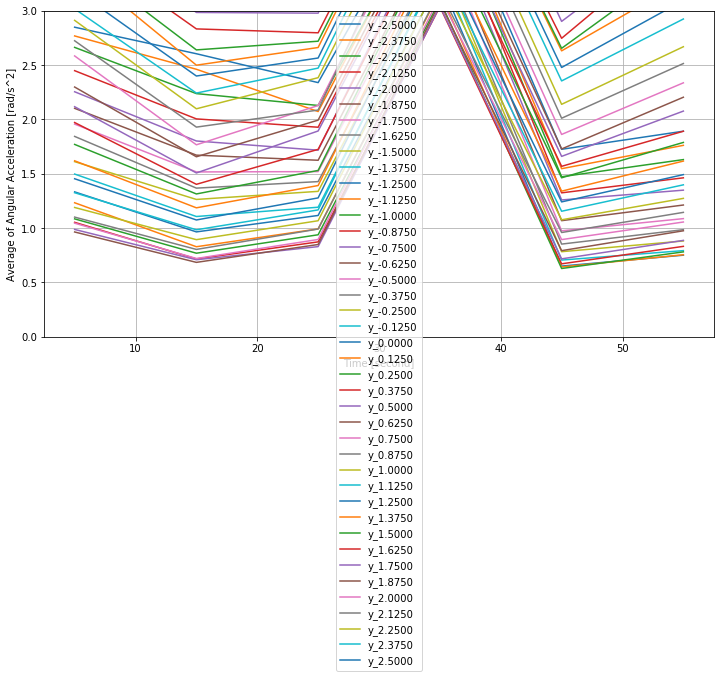

In [14]:
plotA4s(datas,legend,sampling_rate=30,length=300,ylim=[0,3])

iPhoneのデータセットの結果は分かった。ではVirtualGimbalの結果は？

In [9]:
def exec_vg_sd(offset): # Vaio10
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/syukugawara/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j records/2019-04-03_07.27.36.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [10]:
def exec_vg_sd(offset): # Mac + Pallarels
    cmd = './pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j records/2019-04-03_07.27.36.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [17]:
frame_offsets=np.linspace(-2.0,2.0,41)

for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for fo in frame_offsets:
    exec_vg_sd(fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [11]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:2] # X axis only
    else:
        datas = np.append(datas,data[1:2],axis=0) # X axis only


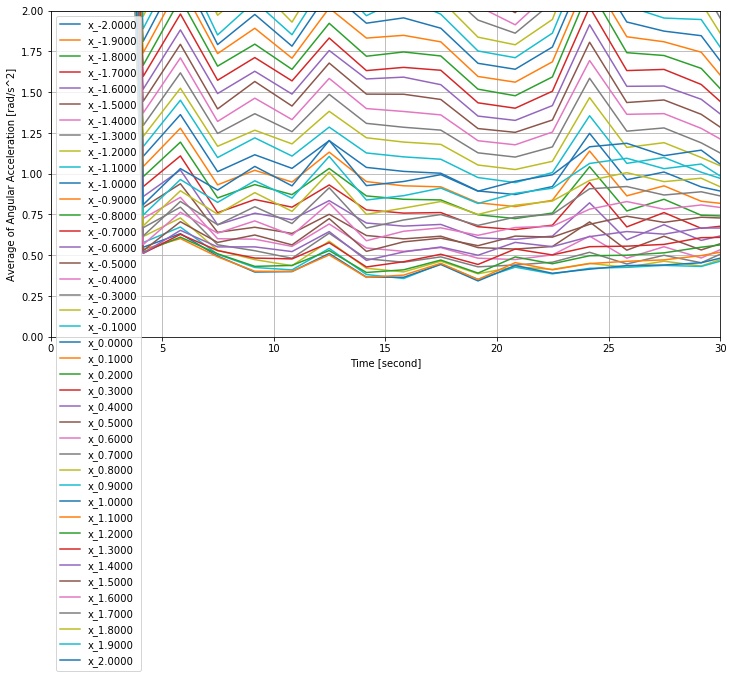

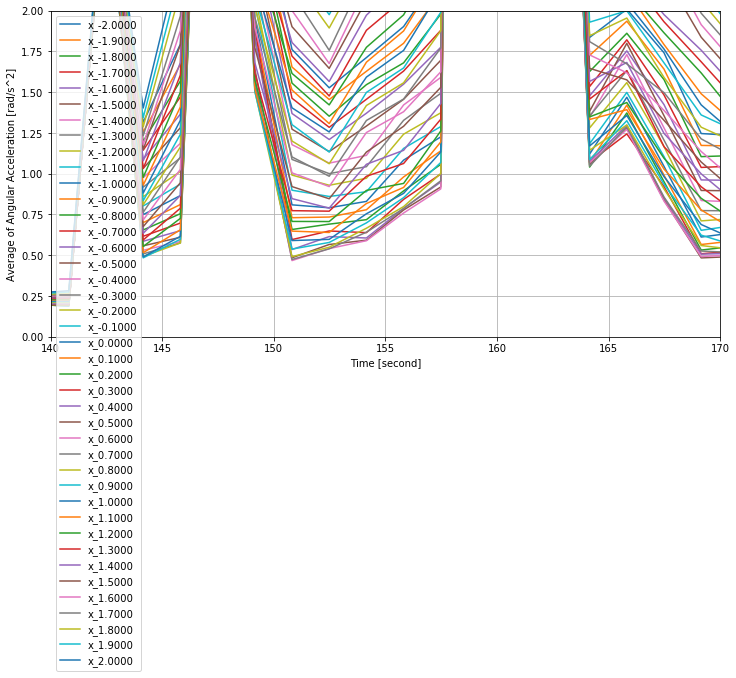

In [12]:
plotA4s(datas,legend,sampling_rate=30,length=50,xlim=[0,30],ylim=[0,2])
plotA4s(datas,legend,sampling_rate=30,length=50,xlim=[140,170],ylim=[0,2])

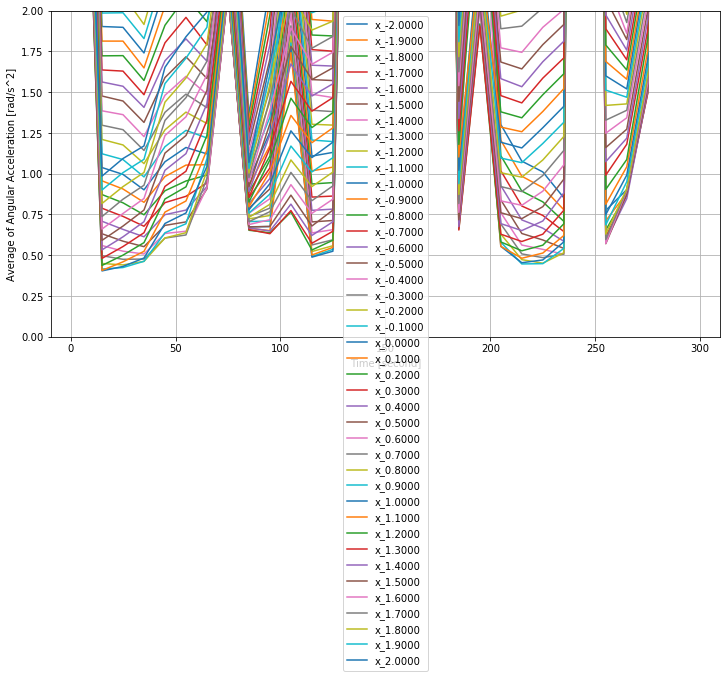

In [13]:
plotA4s(datas,legend,sampling_rate=30,length=300,ylim=[0,2])

In [15]:
legend = []
original_datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    # data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    data = openCSV('../build/latest_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    

    # データを結合する
    if original_datas is None:
        original_datas = data[1:]
    else:
        original_datas = np.append(original_datas,data[1:],axis=0)


In [16]:
def plotRelativeA4s(angular_velocitys,original_angular_velocity,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    plt.figure(figsize=(10,6))

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
    


    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()

No handles with labels found to put in legend.


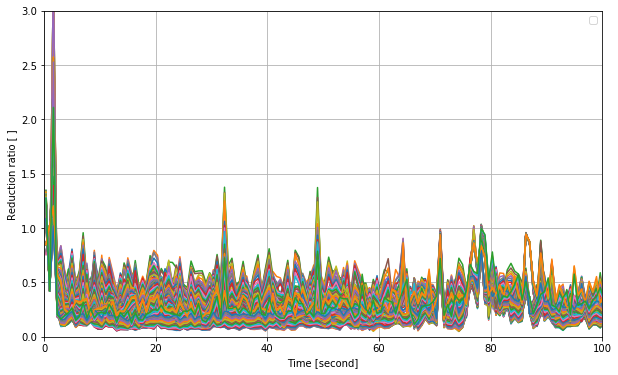

In [17]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,length=20,xlim=[0,100],ylim=[0,3])

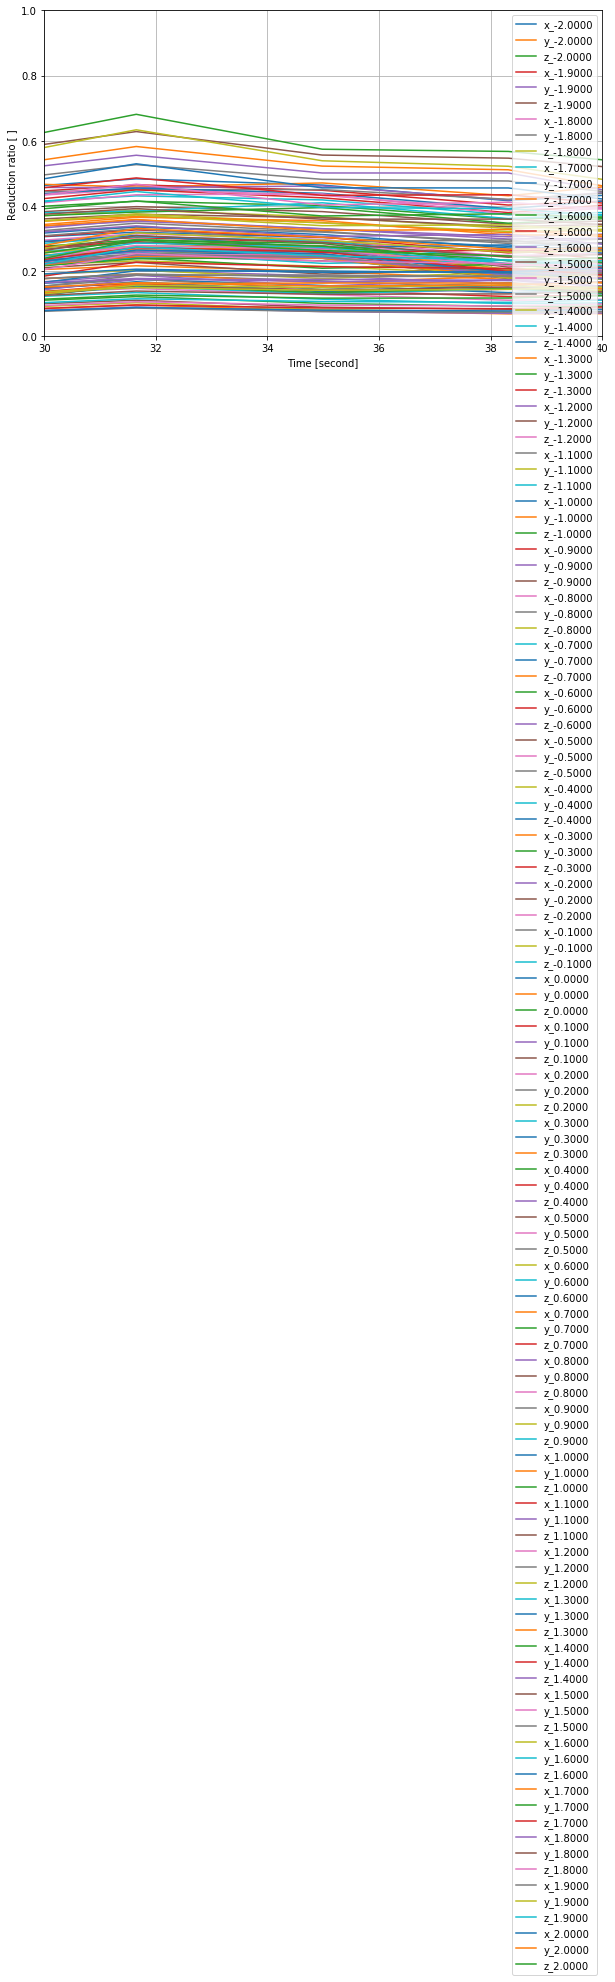

In [18]:
plotRelativeA4s(datas,original_datas, legends=legend, sampling_rate=30.,length=100,xlim=[30,40],ylim=[0,1])

No handles with labels found to put in legend.


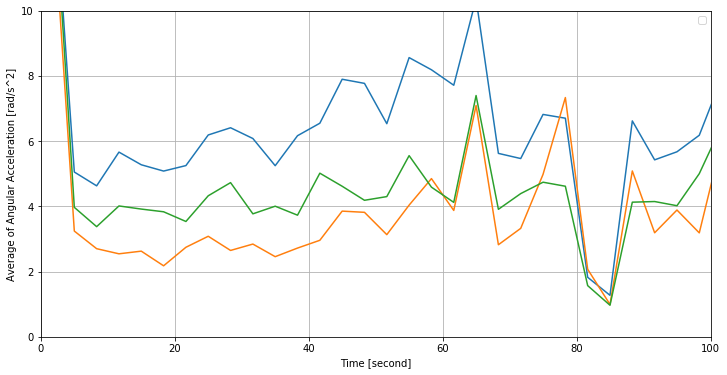

In [19]:
plotA4s(original_datas[0:3],length=100,ylim=[0,10],xlim=[0,100])

No handles with labels found to put in legend.


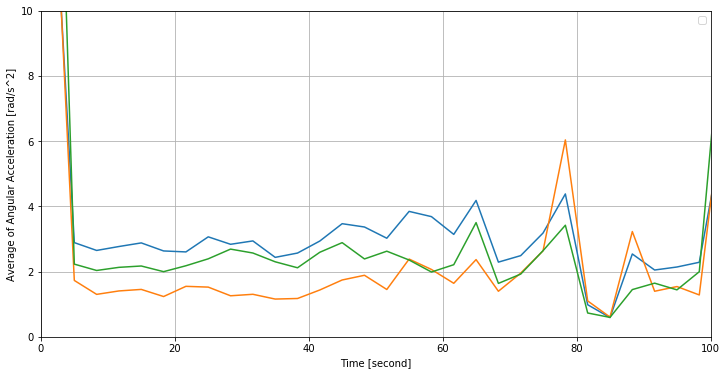

In [20]:
plotA4s(datas[0:3],ylim=[0,10],length=100,xlim=[0,100])

In [21]:
ds = []
for d in datas:
    # print(d.shape)
    aaa = getAverageOfAbsAngularAcceleration(d,30.)
    # print(aaa)
    ds.append(aaa)

In [22]:
legend = []
xdatas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    

    # データを結合する
    if xdatas is None:
        xdatas = data[1:2]
    else:
        xdatas = np.append(xdatas,data[1:2],axis=0)

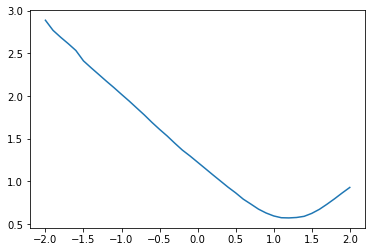

In [23]:
ds = []
for d in xdatas:
    # print(d.shape)
    aaa = getAverageOfAbsAngularAcceleration(d[100:200],30.)
    # print(aaa)
    ds.append(aaa)

plt.plot(frame_offsets,ds)

In [24]:
def plotAverageRelativeA4s(angular_velocitys,original_angular_velocity,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    ratio = []

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
            ratio.append(np.average(a4)/np.average(oa4))
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
            ratio.append(np.average(a4)/np.average(oa4))
        


    rsratio = np.reshape(np.array(ratio),(41,3))

    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,0])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,1])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,2])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()

    return rsratio

No handles with labels found to put in legend.


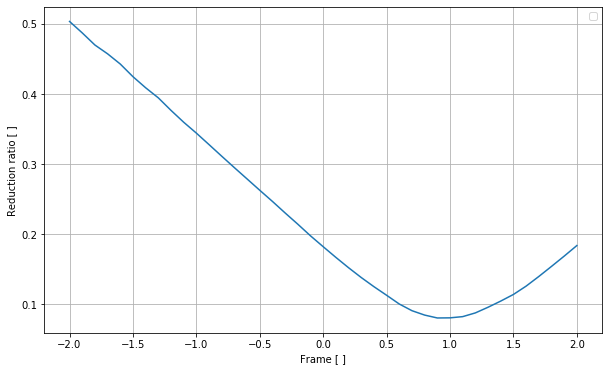

No handles with labels found to put in legend.


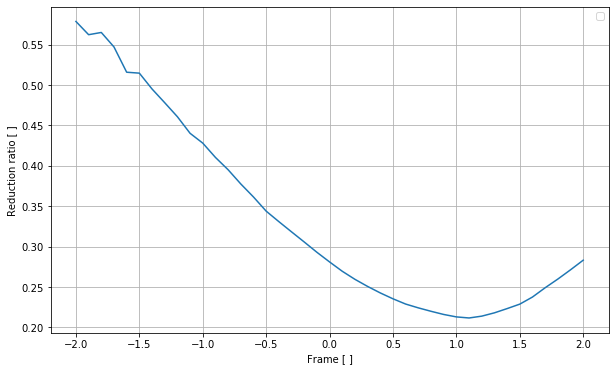

No handles with labels found to put in legend.


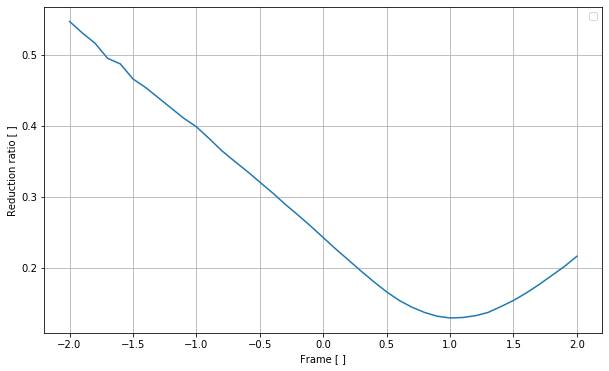

array([[0.5034942 , 0.57871796, 0.54713795],
       [0.48717864, 0.56234521, 0.53103436],
       [0.46990762, 0.56510694, 0.516578  ],
       [0.45733634, 0.54717742, 0.49515725],
       [0.44277414, 0.51590162, 0.48726658],
       [0.4247392 , 0.5147628 , 0.46606279],
       [0.40894961, 0.49516709, 0.45394463],
       [0.3945498 , 0.47818115, 0.4395076 ],
       [0.37669855, 0.4608365 , 0.42508055],
       [0.35980612, 0.44031538, 0.41068409],
       [0.34427602, 0.42817769, 0.39856745],
       [0.32787804, 0.4104729 , 0.38212667],
       [0.31134146, 0.39521058, 0.36484802],
       [0.29500945, 0.3776163 , 0.35010288],
       [0.27891703, 0.36150473, 0.33575465],
       [0.26277109, 0.34398902, 0.32054585],
       [0.24687068, 0.33100332, 0.30541478],
       [0.23041751, 0.3183554 , 0.28932074],
       [0.21439477, 0.30582787, 0.2742247 ],
       [0.1978236 , 0.29308679, 0.25864042],
       [0.18233082, 0.28111321, 0.24230058],
       [0.16709121, 0.26958371, 0.22598476],
       [0.

In [25]:
plotAverageRelativeA4s(datas[:,500:700],original_datas[:,500:700], frame_offset=frame_offsets, sampling_rate=30.,length=20)

No handles with labels found to put in legend.


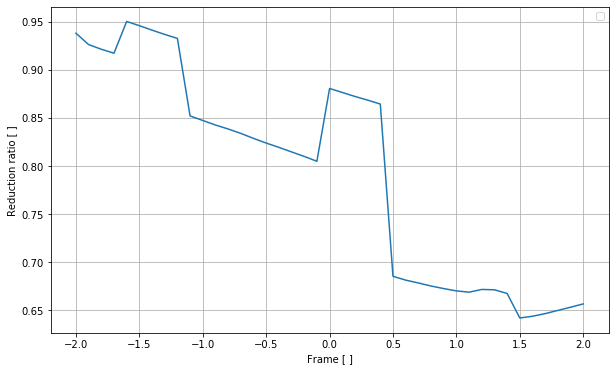

No handles with labels found to put in legend.


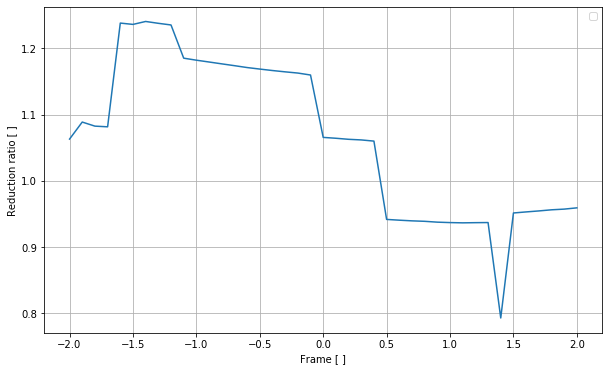

No handles with labels found to put in legend.


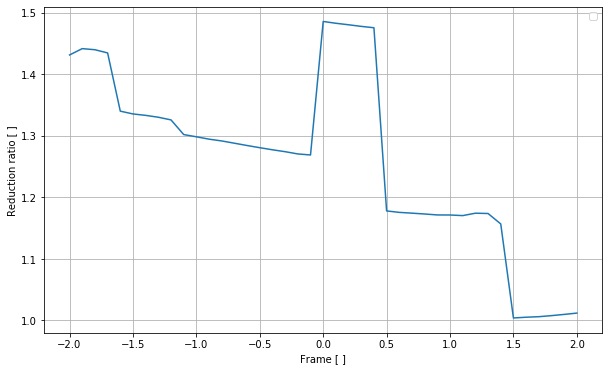

array([[0.93807935, 1.0630855 , 1.43144458],
       [0.9262754 , 1.08878392, 1.44171712],
       [0.92140969, 1.0826188 , 1.43993245],
       [0.91731435, 1.08159543, 1.43473124],
       [0.95029839, 1.23827007, 1.34014162],
       [0.94593186, 1.23627022, 1.33559364],
       [0.94127831, 1.24070969, 1.33327509],
       [0.93681696, 1.23791664, 1.33023531],
       [0.93269842, 1.23541922, 1.32589981],
       [0.85207559, 1.1852667 , 1.30208414],
       [0.8473711 , 1.18221965, 1.29845469],
       [0.84264202, 1.17947751, 1.29462536],
       [0.83852456, 1.17668375, 1.29172351],
       [0.83392102, 1.17394822, 1.28802767],
       [0.82873854, 1.17111102, 1.28428794],
       [0.8239127 , 1.16881086, 1.28073802],
       [0.81940076, 1.16660281, 1.27735633],
       [0.81468543, 1.16461356, 1.27425997],
       [0.80999534, 1.16278954, 1.27059855],
       [0.80494788, 1.15983412, 1.26892939],
       [0.8806284 , 1.0656268 , 1.485853  ],
       [0.87649663, 1.06431   , 1.48291964],
       [0.

In [26]:
plotAverageRelativeA4s(datas[:,0:200],original_datas[:,0:200], frame_offset=frame_offsets, sampling_rate=30.,length=20)

No handles with labels found to put in legend.


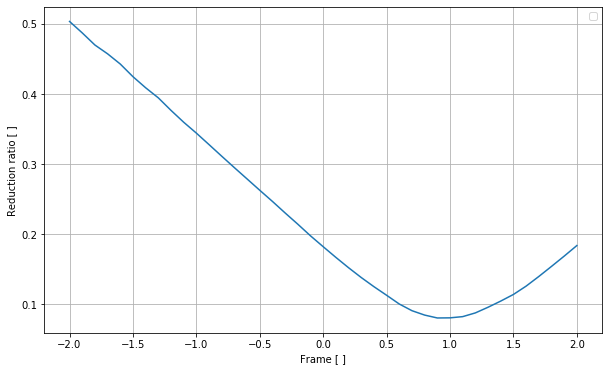

No handles with labels found to put in legend.


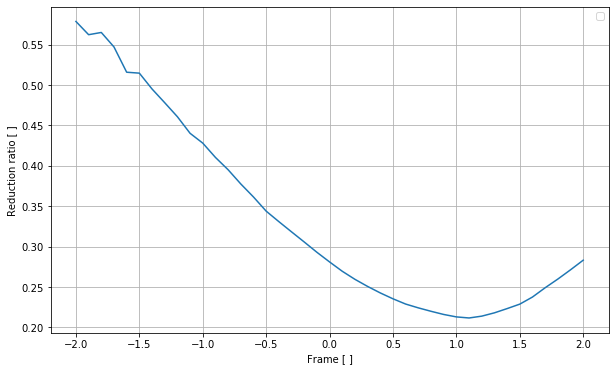

No handles with labels found to put in legend.


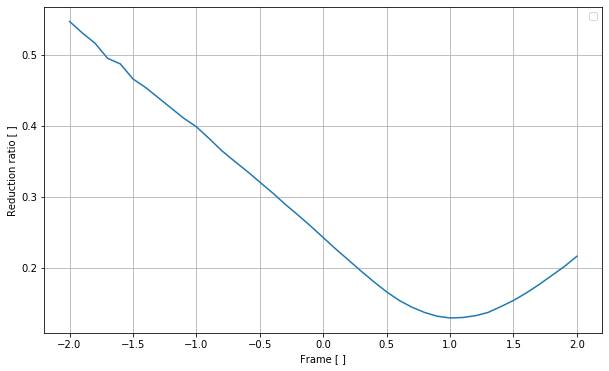

In [27]:
red_ratio = plotAverageRelativeA4s(datas[:,500:700],original_datas[:,500:700], frame_offset=frame_offsets, sampling_rate=30.,length=20)

In [28]:
# 最小値のframeを取得する
print(frame_offsets[np.argmin(red_ratio[:,0])]) # x軸
print(frame_offsets[np.argmin(red_ratio[:,1])]) # y軸
print(frame_offsets[np.argmin(red_ratio[:,2])]) # z軸

0.9000000000000004
1.1
1.0


No handles with labels found to put in legend.


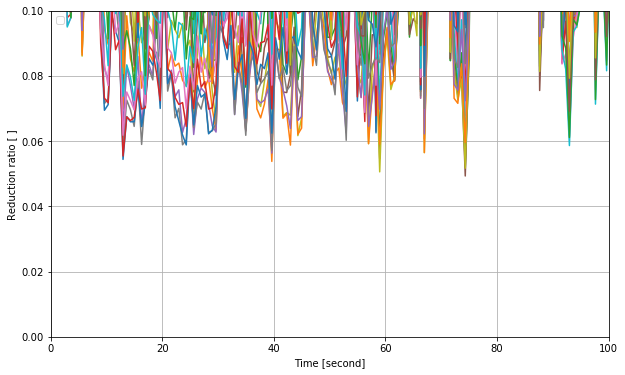

In [29]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,length=20,xlim=[0,100],ylim=[0,0.1])

No handles with labels found to put in legend.


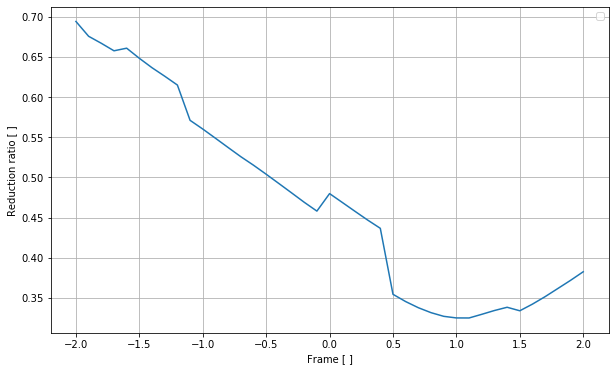

No handles with labels found to put in legend.


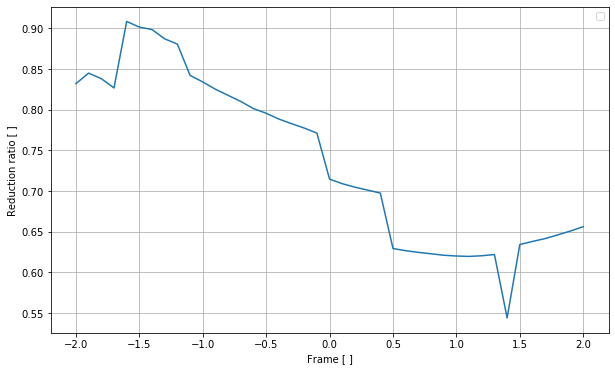

No handles with labels found to put in legend.


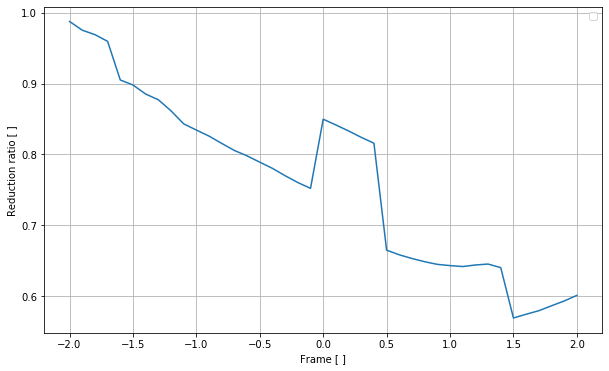

No handles with labels found to put in legend.


0.32506969922930873


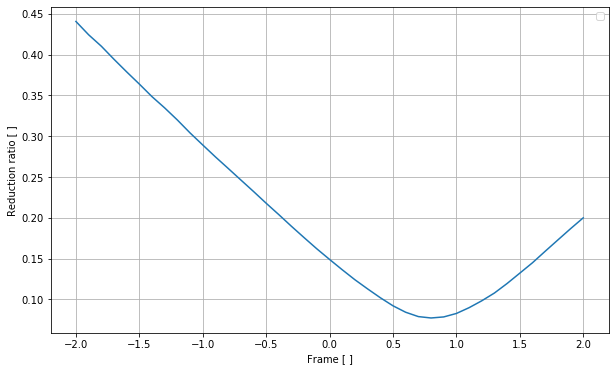

No handles with labels found to put in legend.


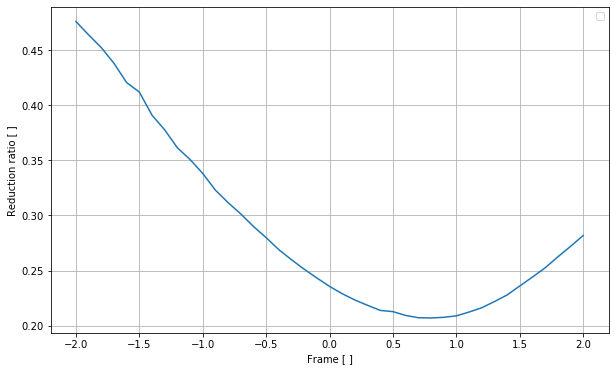

No handles with labels found to put in legend.


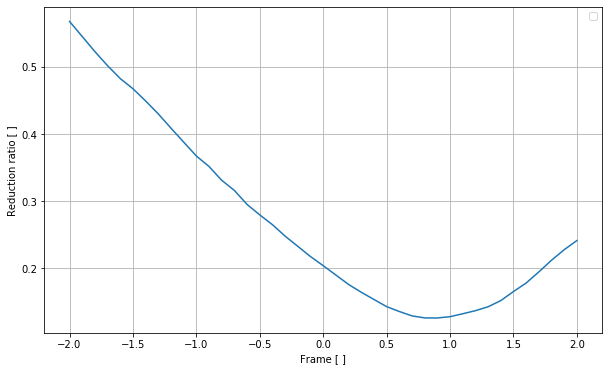

No handles with labels found to put in legend.


0.07729005163524758


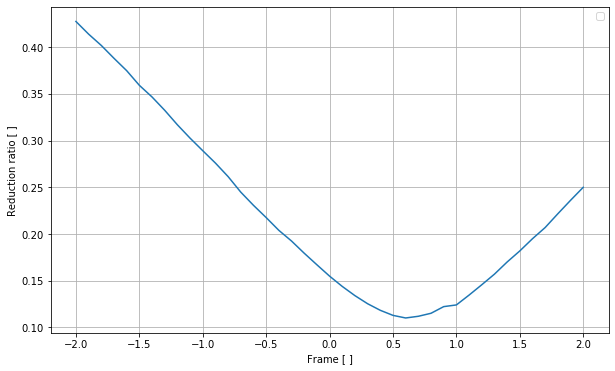

No handles with labels found to put in legend.


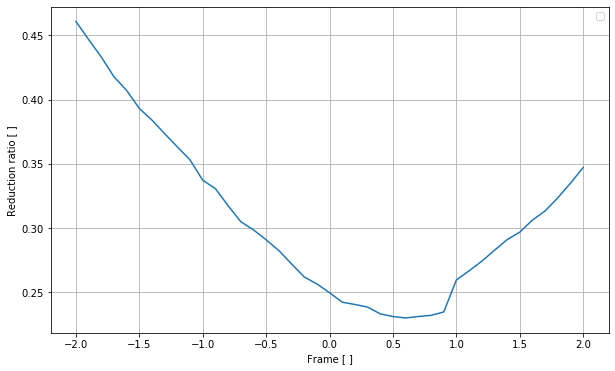

No handles with labels found to put in legend.


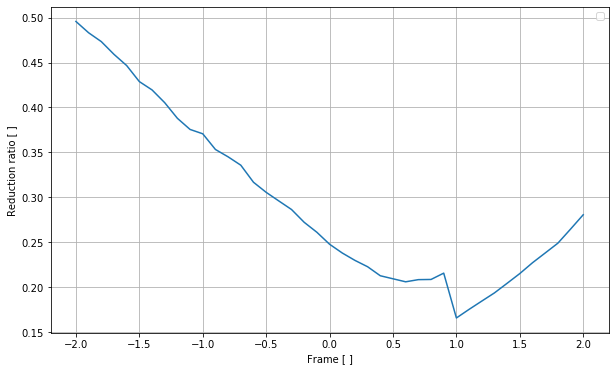

No handles with labels found to put in legend.


0.1101429425581015


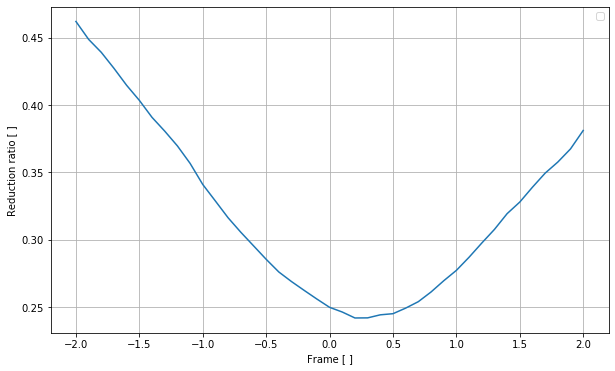

No handles with labels found to put in legend.


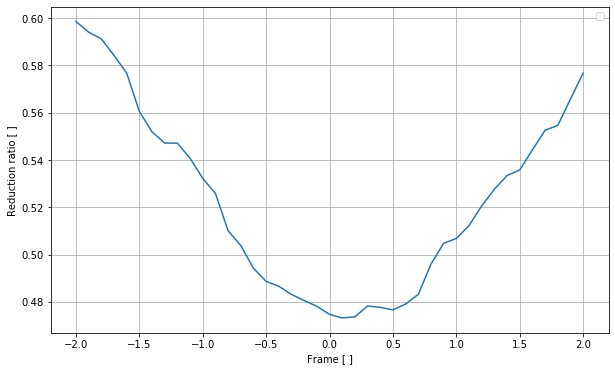

No handles with labels found to put in legend.


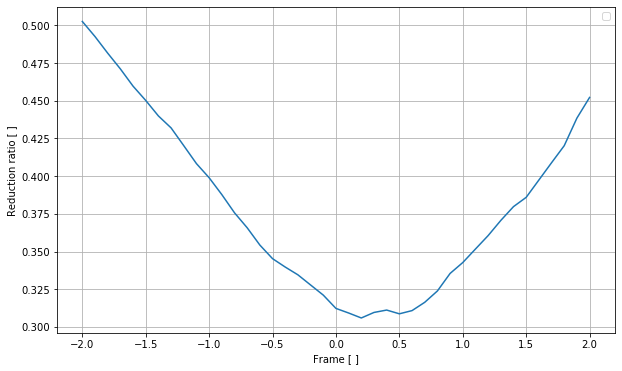

No handles with labels found to put in legend.


0.24182379357687647


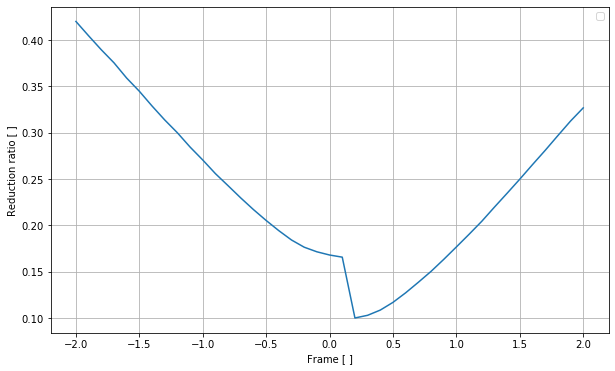

No handles with labels found to put in legend.


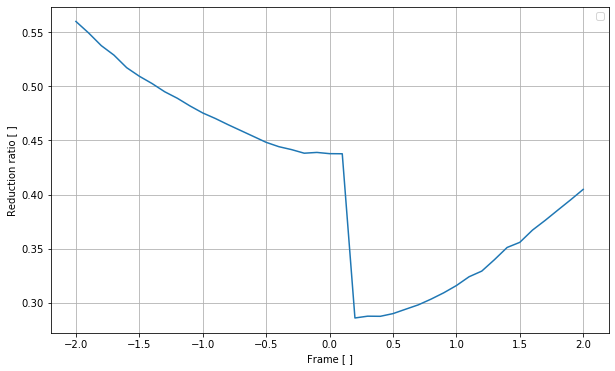

No handles with labels found to put in legend.


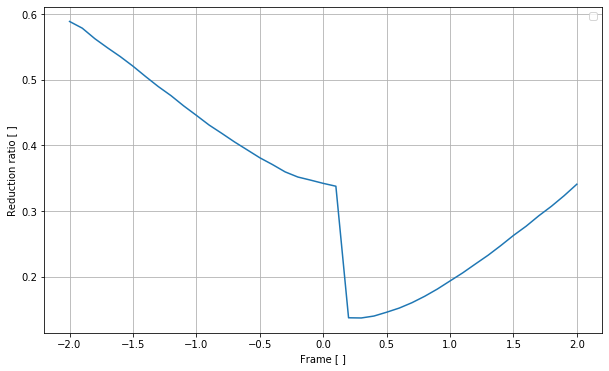

No handles with labels found to put in legend.


0.10003008654469811


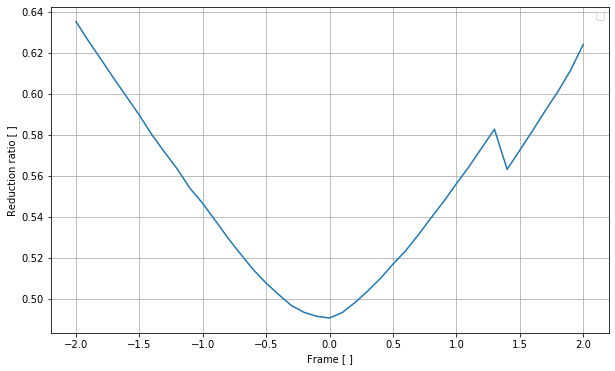

No handles with labels found to put in legend.


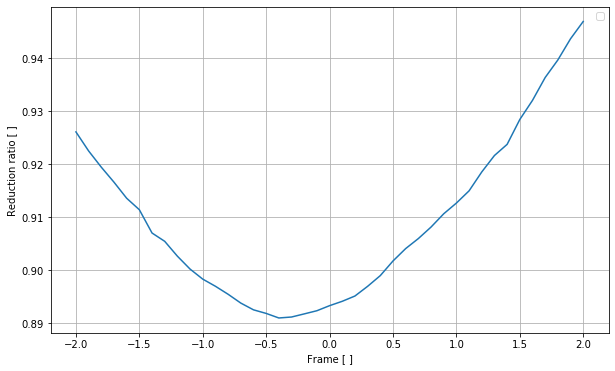

No handles with labels found to put in legend.


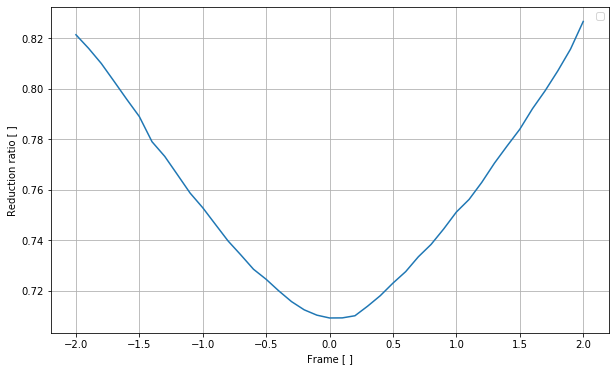

No handles with labels found to put in legend.


0.4907005368836463


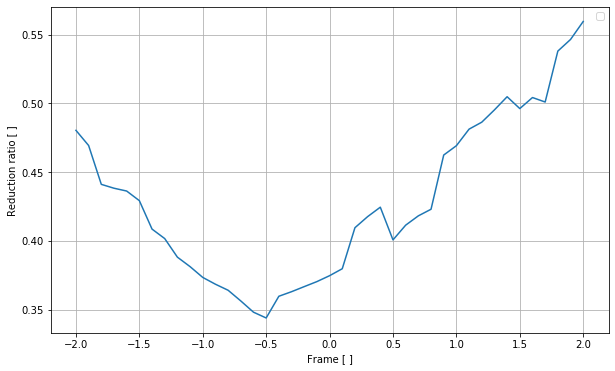

No handles with labels found to put in legend.


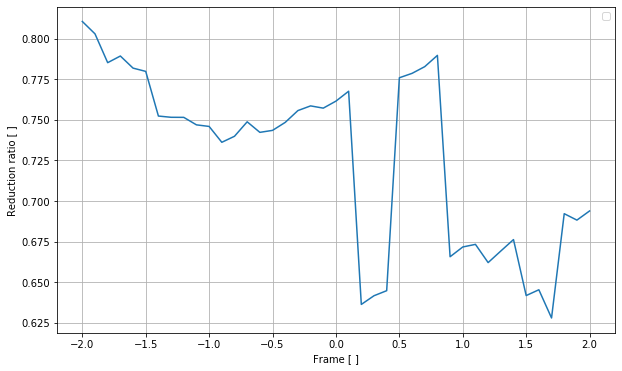

No handles with labels found to put in legend.


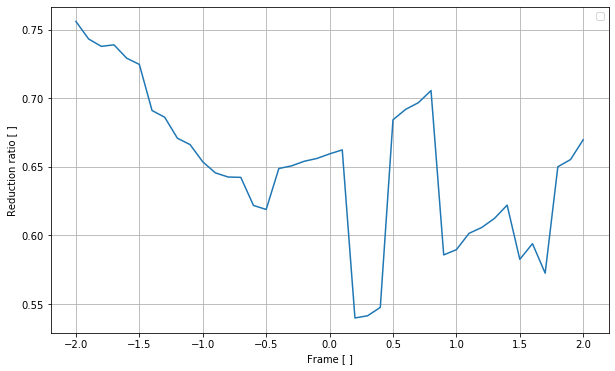

No handles with labels found to put in legend.


0.3439604609964655


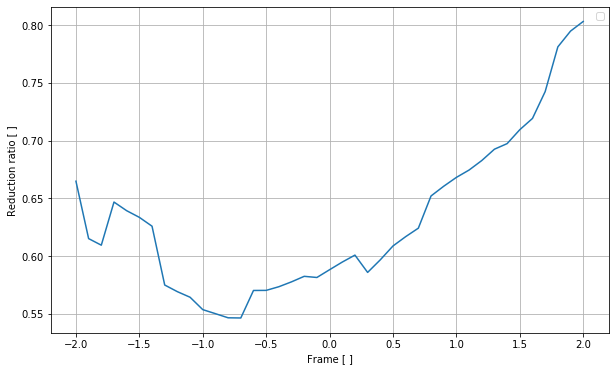

No handles with labels found to put in legend.


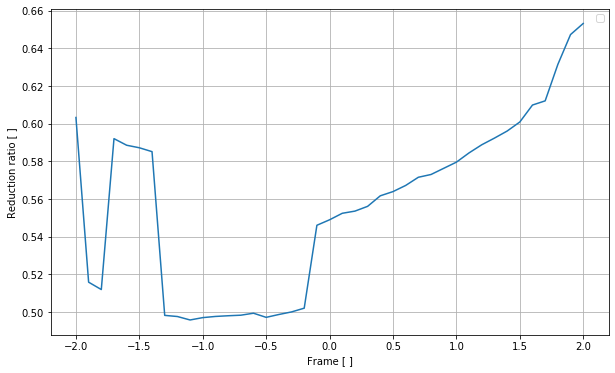

No handles with labels found to put in legend.


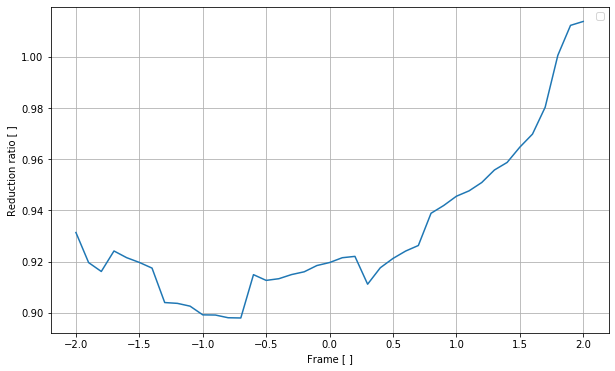

No handles with labels found to put in legend.


0.5464408418519942


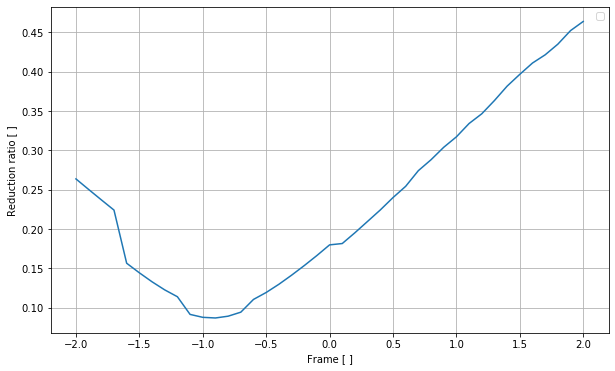

No handles with labels found to put in legend.


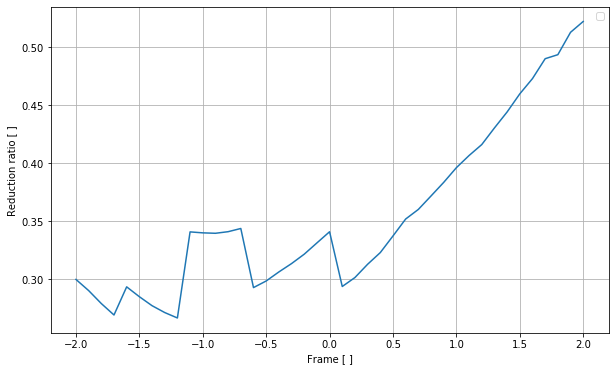

No handles with labels found to put in legend.


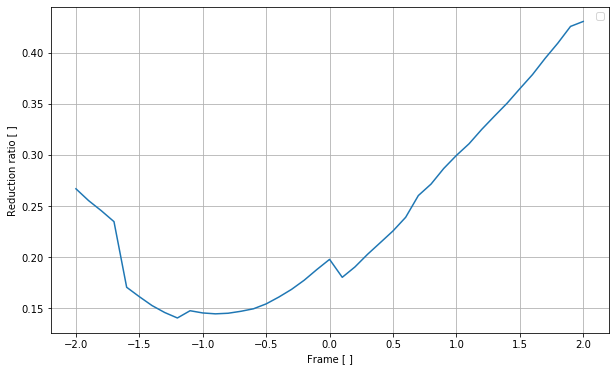

No handles with labels found to put in legend.


0.08683611882138999


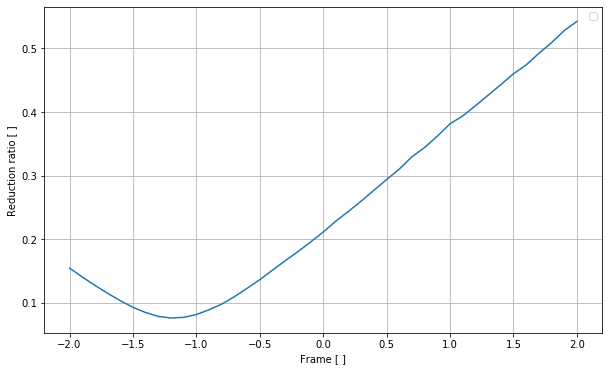

No handles with labels found to put in legend.


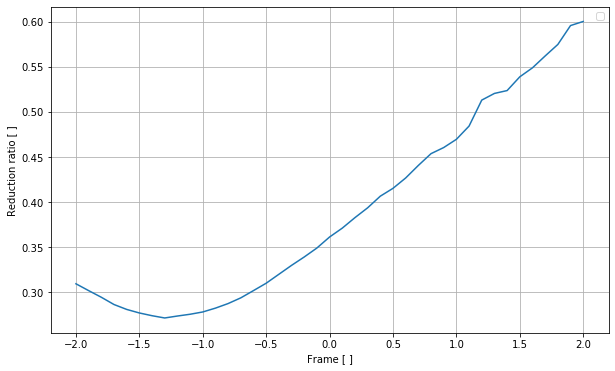

No handles with labels found to put in legend.


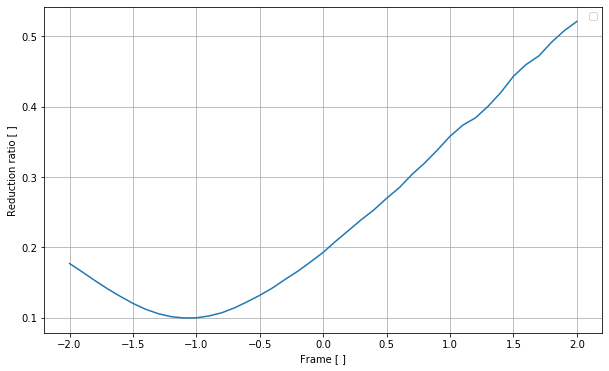

No handles with labels found to put in legend.


0.07632197150025855


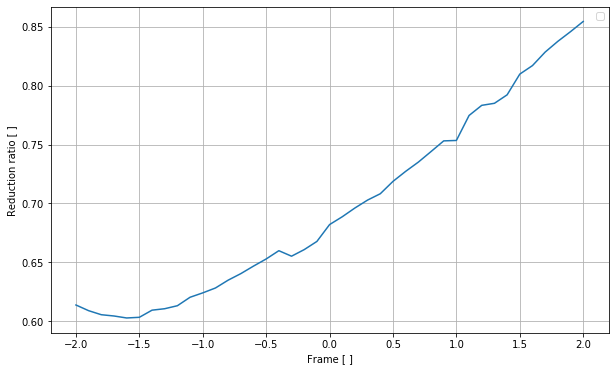

No handles with labels found to put in legend.


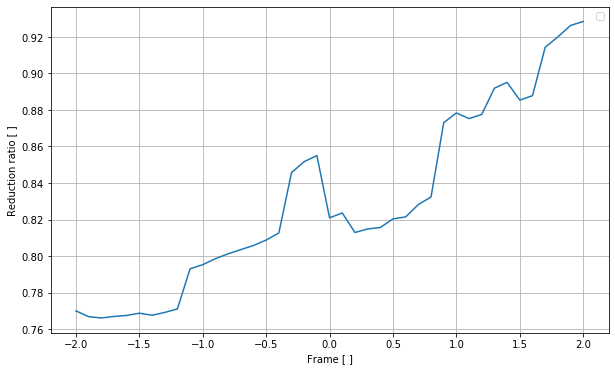

No handles with labels found to put in legend.


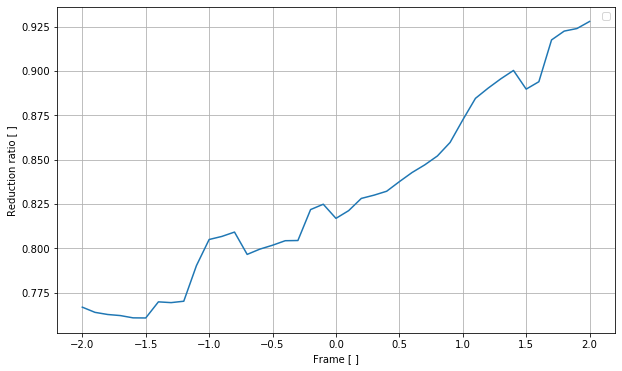

No handles with labels found to put in legend.


0.6025640314241902


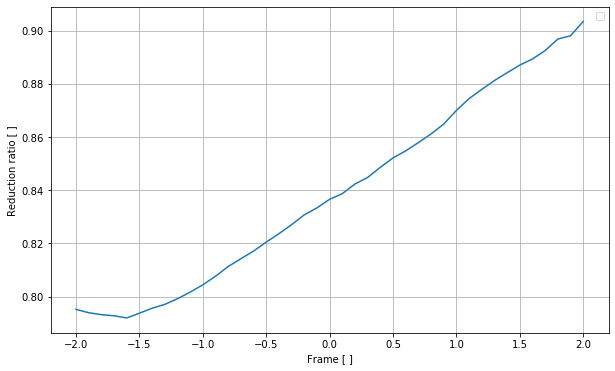

No handles with labels found to put in legend.


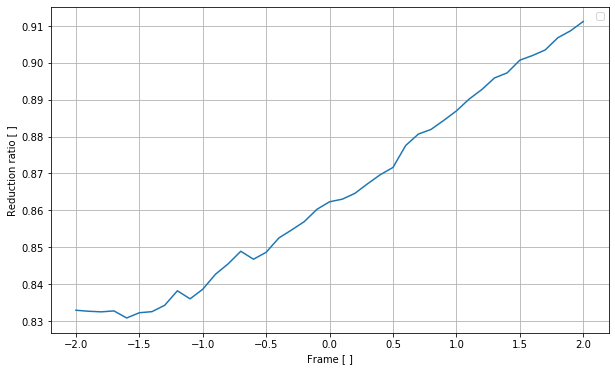

No handles with labels found to put in legend.


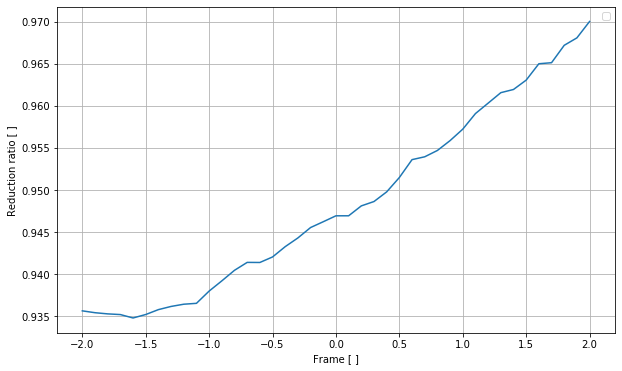

No handles with labels found to put in legend.


0.7920095011082616


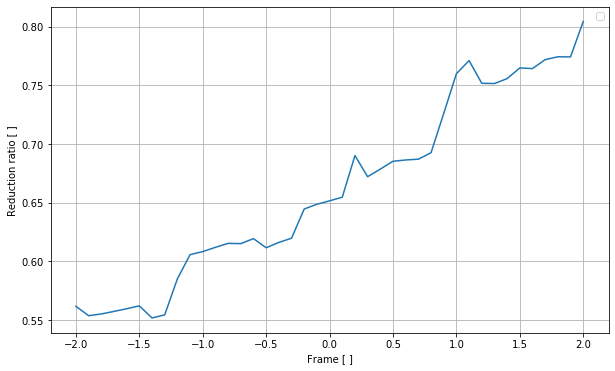

No handles with labels found to put in legend.


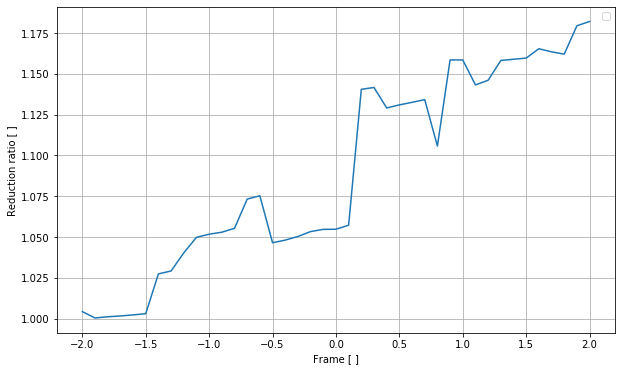

No handles with labels found to put in legend.


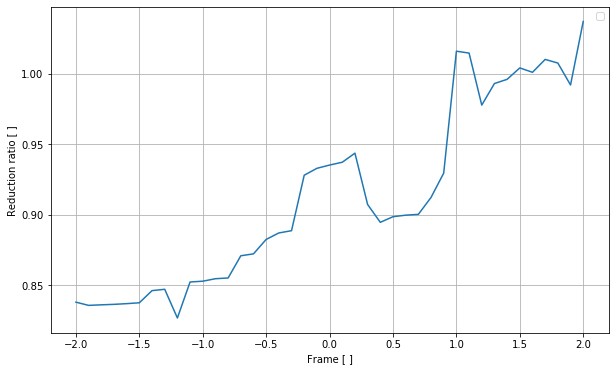

0.5518025358235712


In [30]:
min_red_tatio = []
ave_frame = []
# length = 200
length = 719
for i in range(0,len(datas[0]),length):
    red_ratio = plotAverageRelativeA4s(datas[:,i:i+length],original_datas[:,i:i+length], frame_offset=frame_offsets, sampling_rate=30.,length=20)
    print(min(red_ratio[:,0]))
    x_axis_ratio = red_ratio[:,0]
    x_axis_min_value_index = np.argmin(x_axis_ratio)
    
    min_red_tatio.append(frame_offsets[x_axis_min_value_index])
    ave_frame.append((i + length/2))

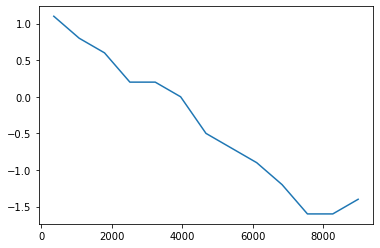

In [35]:
plt.plot(ave_frame,min_red_tatio)

In [32]:
len(min_red_tatio)

13

In [33]:
min_red_tatio[0]

1.1

In [34]:
min_red_tatio

[1.1,
 0.8000000000000003,
 0.6000000000000001,
 0.20000000000000018,
 0.20000000000000018,
 0.0,
 -0.5,
 -0.7,
 -0.8999999999999999,
 -1.2,
 -1.6,
 -1.6,
 -1.4]

In [38]:
A = np.array([ave_frame,np.ones(len(ave_frame))])
A = A.T
a,b = np.linalg.lstsq(A,min_red_tatio)[0]

<ipython-input-38-4fadb4c5e18a>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a,b = np.linalg.lstsq(A,min_red_tatio)[0]


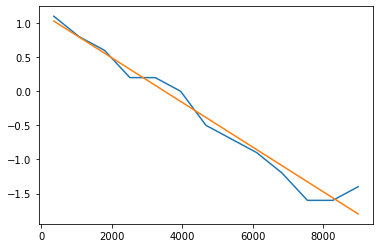

In [47]:
plt.plot(ave_frame,min_red_tatio)
plt.plot(ave_frame,(a*np.array(ave_frame)+b))

In [48]:
a

-0.0003278362805483809

In [49]:
b

1.1475274725274724